In [2]:
import numpy as np
samples = ['The cat jump over the dog', 'The dog ate my homework']

#我们先将每个单词放置到一个哈希表中
token_index = {}
for sample in samples:
    #将一个句子分解成多个单词
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
#设置句子的最大长度
max_length = 10
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[: max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        print("{0} -> {1}".format(word, results[i, j]))

The -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
cat -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
jump -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
over -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
the -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
dog -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
dog -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
ate -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
my -> [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
homework -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [3]:
from keras.preprocessing.text import Tokenizer

def oneHotEncode(samples):
    #只考虑最常使用的前1000个单词
    tokenizer = Tokenizer(num_words = 1000)
    tokenizer.fit_on_texts(samples)
    #把句子分解成单词数组
    sequences = tokenizer.texts_to_sequences(samples)
    return sequences

samples = ['The cat jump over the dog', 'The dog ate my homework']
vecs = oneHotEncode(samples)
print(vecs)

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


[[1, 3, 4, 5, 1, 2], [1, 2, 6, 7, 8]]


In [4]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# 定义一系列简单文本，前一半表示赞美，后一半表示批判
docs = ['Well done',
'Good work',
'Great effort',
'nice work',
'Excellent',
'Weak',
'Poor effort',
'quit bad',
'it is terrible',
'like a shit']
# 属于赞美性质的文本用1表示，属于匹配性质的文本用0表示
labels = array([1,1,1,1,1,0,0,0,0,0])
# 假定单词量有50个
vocab_size = 50

encoded_docs = oneHotEncode(docs)
print(encoded_docs)
# 规定每个文本4个单词，不足4个的用0补足
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

model = Sequential()
'''
Embedding层本质上是一个矩阵，高位vocab_size, 宽为8，矩阵的每一行对应每个单词向量
由于我们设定每篇文本的单词量为4个，每个单词对应一个8元素的向量，
因此我们把一篇文本对应的向量也就是一个含有4个元素的向量输入Embedding层后，
得到4*8的一个二维矩阵，其中的4对应输入文本向量中元素个数，8对应每个单词的向量维度
'''
emebdding_layer = Embedding(vocab_size, 8, input_length=max_length)
model.add(emebdding_layer)

print("vector for word Well before train is:")
print(emebdding_layer.get_weights()[0][0])

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())
# 训练网络
model.fit(padded_docs, labels, epochs=50, verbose=0)

print("vector for word Well after train is:")
print(emebdding_layer.get_weights()[0][0])

[[3, 4], [5, 1], [6, 2], [7, 1], [8], [9], [10, 2], [11, 12], [13, 14, 15], [16, 17, 18]]
[[ 3  4  0  0]
 [ 5  1  0  0]
 [ 6  2  0  0]
 [ 7  1  0  0]
 [ 8  0  0  0]
 [ 9  0  0  0]
 [10  2  0  0]
 [11 12  0  0]
 [13 14 15  0]
 [16 17 18  0]]
vector for word Well before train is:
[-0.02657006  0.0383096   0.02233554  0.04059597  0.04437181 -0.02838534
 -0.0444255  -0.0069304 ]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
vector for word Well afte

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#建立单词与编号之间的对应关系
word2Num = {}
for idx, doc in enumerate(docs):
    words = doc.split()
    for i, word in enumerate(words):
        print("{0} => {1}".format(word, encoded_docs[idx][i]))
        word2Num[word] = encoded_docs[idx][i]

embeddings = emebdding_layer.get_weights()[0]
#建立单词与向量之间的连续
vectors = []
words = []
for word, num in word2Num.items():
    print("{0} => {1}".format(word, embeddings[num]))
    words.append(word)
    vectors.append(embeddings[num])
    

Well => 3
done => 4
Good => 5
work => 1
Great => 6
effort => 2
nice => 7
work => 1
Excellent => 8
Weak => 9
Poor => 10
effort => 2
quit => 11
bad => 12
it => 13
is => 14
terrible => 15
like => 16
a => 17
shit => 18
Well => [-0.06035617 -0.09605784 -0.00366253  0.02276089  0.07790188  0.09377208
  0.04197539 -0.05284381]
done => [ 0.05714667  0.05540325  0.05225036  0.0978943  -0.00073306  0.03376441
  0.02740954 -0.00794439]
Good => [-0.0802986  -0.03346889 -0.06513028  0.07619027  0.06500677  0.05002201
  0.08673604 -0.0644387 ]
work => [ 0.06323677  0.05835621  0.02338395  0.08516317  0.0406943   0.09516043
  0.06901971 -0.08673722]
Great => [-0.02533222 -0.04910561 -0.09314691  0.06871016  0.07945779  0.05575632
  0.06508854 -0.0265587 ]
effort => [-0.04288376  0.00628933 -0.0250146   0.01110729  0.00334438 -0.0377573
 -0.05183166 -0.00887822]
nice => [-0.05611075 -0.03740417 -0.00318421  0.01730423  0.07851893  0.06143999
  0.00638593 -0.0932235 ]
Excellent => [-0.02988222 -0.07680

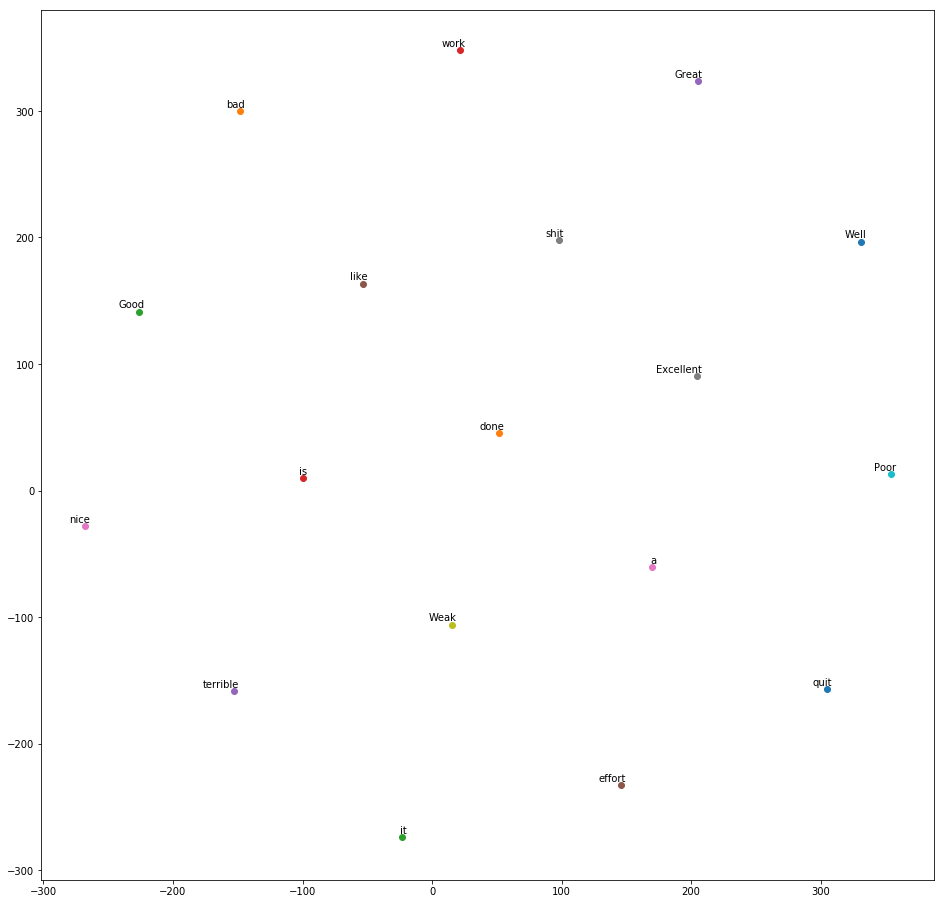

In [6]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5,2), textcoords='offset points',
                ha='right',va='bottom')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.


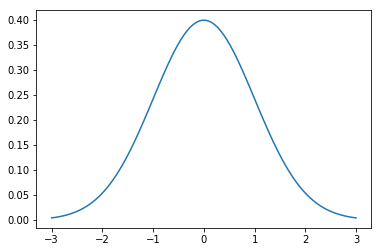

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.show()

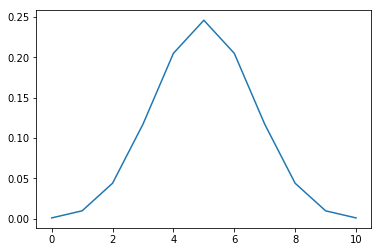

In [8]:
import scipy, scipy.stats
x = scipy.linspace(0,10,11)
pmf = scipy.stats.binom.pmf(x,10,0.5)
import pylab
pylab.plot(x,pmf)

In [9]:
import pandas as pd
df = pd.read_json('/Users/chenyi/Documents/人工智能出书/数据集/第6章/News_Category_Dataset.json', lines=True)
df.head()

ValueError: Expected object or value

In [111]:
df.category = df.category.map(lambda x:"WORLDPOST" if x == "THE WORLDPOST" else x)
categories = df.groupby('category')
print("total categories: ", categories.ngroups)
print(categories.size())

total categories:  30
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       3858
BUSINESS           4254
COLLEGE            1144
COMEDY             3971
CRIME              2893
EDUCATION          1004
ENTERTAINMENT     14257
FIFTY              1401
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
IMPACT             2602
LATINO VOICES      1129
MEDIA              2815
PARENTS            3955
POLITICS          32739
QUEER VOICES       4995
RELIGION           2556
SCIENCE            1381
SPORTS             4167
STYLE              2254
TASTE              2096
TECH               1231
TRAVEL             2145
WEIRD NEWS         2670
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int64


In [112]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot
df['text'] = df.headline + " " + df.short_description

# 将单词进行标号
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

#记录每条数据的单词数
df['word_length'] = df.words.apply(lambda i: len(i))
#清除单词数不足5个的数据条目
df = df[df.word_length >= 5]
df.word_length.describe()

count    124068.000000
mean         26.128422
std          14.366390
min           5.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         248.000000
Name: word_length, dtype: float64

In [133]:
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

# 将分类进行编号
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

In [134]:
import numpy as np
import keras.utils as utils
from sklearn.model_selection import train_test_split
import numpy as np



X = np.array(X)
Y = utils.to_categorical(list(df.c2id))


# 将数据分成两部分,80%用于训练，20%用于测试

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)


In [1]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100
embeddings_index = {}
f = open('/Users/chenyi/Documents/人工智能/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' %len(embeddings_index))

NameError: name 'tokenizer' is not defined

In [149]:
from keras.initializers import Constant

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    #根据单词挑选出对应向量
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
     
embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, 
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length = maxlen,
                            trainable=False
                           )

In [147]:
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
#当结果是输出多个分类的概率时，用softmax激活函数,它将为30个分类提供不同的可能性概率值
model.add(layers.Dense(len(int_category), activation='softmax'))

#对于输出多个分类结果，最好的损失函数是categorical_crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 50, 100)           8662800   
_________________________________________________________________
flatten_30 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_45 (Dense)             (None, 30)                1950      
Total params: 8,984,814
Trainable params: 322,014
Non-trainable params: 8,662,800
_________________________________________________________________


In [148]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Train on 99254 samples, validate on 24814 samples
Epoch 1/20
99254/99254 [==============================] - 6s 56us/step - loss: 2.1679 - acc: 0.4149 - val_loss: 1.8760 - val_acc: 0.4746
Epoch 2/20
99254/99254 [==============================] - 3s 26us/step - loss: 1.7060 - acc: 0.5123 - val_loss: 1.7845 - val_acc: 0.4948
Epoch 3/20
99254/99254 [==============================] - 3s 31us/step - loss: 1.5265 - acc: 0.5562 - val_loss: 1.7548 - val_acc: 0.4976
Epoch 4/20
99254/99254 [==============================] - 4s 39us/step - loss: 1.4032 - acc: 0.5863 - val_loss: 1.7547 - val_acc: 0.5069
Epoch 5/20
99254/99254 [==============================] - 4s 37us/step - loss: 1.3097 - acc: 0.6115 - val_loss: 1.7809 - val_acc: 0.4988
Epoch 6/20
99254/99254 [==============================] - 3s 35us/step - loss: 1.2281 - acc: 0.6340 - val_loss: 1.7943 - val_acc: 0.5052
Epoch 7/20
99254/99254 [==============================] - 3s 34us/step - loss: 1.1542 - acc: 0.6559 - val_loss: 1.8075 - val_acc

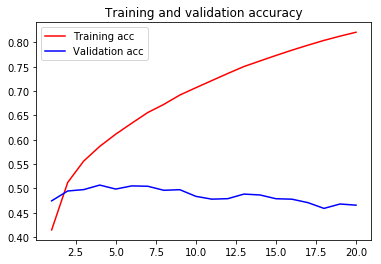

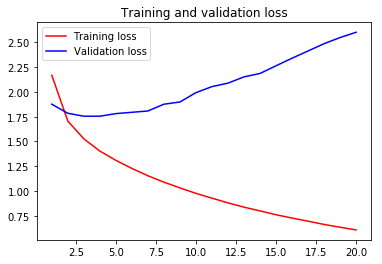

In [152]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [158]:
from keras.layers import SimpleRNN
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(32))
#当结果是输出多个分类的概率时，用softmax激活函数,它将为30个分类提供不同的可能性概率值
model.add(layers.Dense(len(int_category), activation='softmax'))

#对于输出多个分类结果，最好的损失函数是categorical_crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Train on 99254 samples, validate on 24814 samples
Epoch 1/20
99254/99254 [==============================] - 15s 147us/step - loss: 2.7574 - acc: 0.3031 - val_loss: 2.5640 - val_acc: 0.3442
Epoch 2/20
99254/99254 [==============================] - 10s 103us/step - loss: 2.5337 - acc: 0.3430 - val_loss: 2.5161 - val_acc: 0.3418
Epoch 3/20
99254/99254 [==============================] - 11s 110us/step - loss: 2.4556 - acc: 0.3609 - val_loss: 2.4761 - val_acc: 0.3704
Epoch 4/20
99254/99254 [==============================] - 12s 118us/step - loss: 2.3843 - acc: 0.3727 - val_loss: 2.3353 - val_acc: 0.3851
Epoch 5/20
99254/99254 [==============================] - 12s 125us/step - loss: 2.3284 - acc: 0.3830 - val_loss: 2.2903 - val_acc: 0.3916
Epoch 6/20
99254/99254 [==============================] - 13s 128us/step - loss: 2.2816 - acc: 0.3911 - val_loss: 2.2600 - val_acc: 0.3993
Epoch 7/20
99254/99254 [==============================] - 13s 130us/step - loss: 2.2636 - acc: 0.3919 - val_loss: 2.

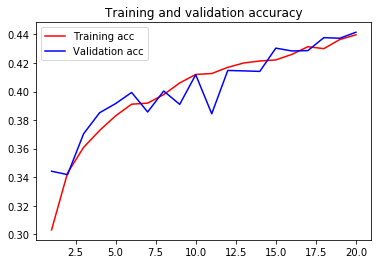

In [159]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.show()

In [160]:
from keras.layers import LSTM
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(32))
#当结果是输出多个分类的概率时，用softmax激活函数,它将为30个分类提供不同的可能性概率值
model.add(layers.Dense(len(int_category), activation='softmax'))

#对于输出多个分类结果，最好的损失函数是categorical_crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Train on 99254 samples, validate on 24814 samples
Epoch 1/20
99254/99254 [==============================] - 31s 317us/step - loss: 2.5276 - acc: 0.3465 - val_loss: 2.1794 - val_acc: 0.4249
Epoch 2/20
99254/99254 [==============================] - 24s 239us/step - loss: 2.0303 - acc: 0.4538 - val_loss: 1.9058 - val_acc: 0.4759
Epoch 3/20
99254/99254 [==============================] - 25s 248us/step - loss: 1.8169 - acc: 0.4970 - val_loss: 1.7430 - val_acc: 0.5130
Epoch 4/20
99254/99254 [==============================] - 28s 284us/step - loss: 1.6960 - acc: 0.5260 - val_loss: 1.6655 - val_acc: 0.5297
Epoch 5/20
99254/99254 [==============================] - 29s 294us/step - loss: 1.6164 - acc: 0.5444 - val_loss: 1.6013 - val_acc: 0.5456
Epoch 6/20
99254/99254 [==============================] - 29s 290us/step - loss: 1.5591 - acc: 0.5589 - val_loss: 1.5559 - val_acc: 0.5565
Epoch 7/20
99254/99254 [==============================] - 33s 331us/step - loss: 1.5182 - acc: 0.5677 - val_loss: 1.

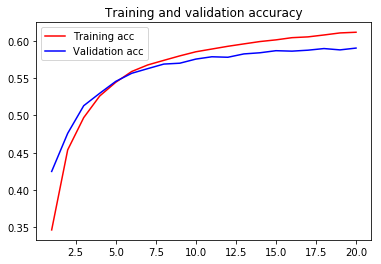

In [161]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.show()

In [165]:
from keras.layers import 
model = Sequential()
model.add(embedding_layer)
#使用一维卷积网络切割输入数据，参数5表示每各个单词作为切割小段
model.add(layers.Conv1D(32, 5, activation='relu'))
#参数3表示，上层传下来的数据中，从每3个数值中抽取最大值
model.add(layers.MaxPooling1D(3))
#添加一个有记忆性的GRU层，其原理与LSTM相同，运行速度更快，准确率有所降低
model.add(layers.GRU(32, dropout=0.1))

model.add(layers.Dense(len(int_category), activation='softmax'))

#对于输出多个分类结果，最好的损失函数是categorical_crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Train on 99254 samples, validate on 24814 samples
Epoch 1/20
99254/99254 [==============================] - 21s 216us/step - loss: 2.4897 - acc: 0.3613 - val_loss: 2.1840 - val_acc: 0.4110
Epoch 2/20
99254/99254 [==============================] - 14s 144us/step - loss: 2.0911 - acc: 0.4362 - val_loss: 1.9449 - val_acc: 0.4645
Epoch 3/20
99254/99254 [==============================] - 15s 148us/step - loss: 1.9099 - acc: 0.4731 - val_loss: 1.8141 - val_acc: 0.4965
Epoch 4/20
99254/99254 [==============================] - 15s 156us/step - loss: 1.8031 - acc: 0.4984 - val_loss: 1.7219 - val_acc: 0.5185
Epoch 5/20
99254/99254 [==============================] - 15s 153us/step - loss: 1.7296 - acc: 0.5160 - val_loss: 1.6611 - val_acc: 0.5344
Epoch 6/20
99254/99254 [==============================] - 16s 157us/step - loss: 1.6754 - acc: 0.5302 - val_loss: 1.6159 - val_acc: 0.5428
Epoch 7/20
99254/99254 [==============================] - 20s 197us/step - loss: 1.6323 - acc: 0.5413 - val_loss: 1.

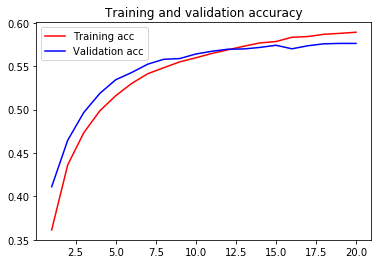

In [166]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.show()